# Pelatihan, Tuning, dan Evaluasi Model

In [5]:
import os
import sys
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skimage.feature import hog, local_binary_pattern

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from src.config import (
    DATA_RAW_PATH, RESULTS_PATH, SAVED_MODEL_PATH, CLASSES, IMAGE_SIZE,
    HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK, 
    TEST_SIZE, RANDOM_STATE
)
from src.utils.logger import logger
from src.utils.dataset_loader import load_images_from_folder
from src.utils.metrics import evaluate_model, plot_confusion_matrix

## Contained Code

In [6]:
def resize_image(image):
    return cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def normalize_image(image):
    return image.astype('float32') / 255.0

def preprocess_image_for_feature_extraction(image):
    resized_color_uint8 = resize_image(image)
    gray_image = to_grayscale(resized_color_uint8)
    normalized_gray = normalize_image(gray_image)
    normalized_color = normalize_image(resized_color_uint8)
    return normalized_gray, normalized_color

def extract_hog_features(gray_image):
    return hog(gray_image, orientations=HOG_ORIENTATIONS, pixels_per_cell=HOG_PIXELS_PER_CELL,
               cells_per_block=HOG_CELLS_PER_BLOCK, block_norm='L2-Hys', visualize=False, transform_sqrt=True)

def extract_color_histogram(color_image):
    hsv_image = cv2.cvtColor((color_image * 255).astype(np.uint8), cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [32], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [32], [0, 256])
    cv2.normalize(hist_h, hist_h)
    cv2.normalize(hist_s, hist_s)
    cv2.normalize(hist_v, hist_v)
    return np.concatenate((hist_h, hist_s, hist_v)).flatten()

def extract_lbp_features(gray_image):
    gray_image_uint8 = (gray_image * 255).astype(np.uint8)
    radius, n_points = 8, 24
    lbp = local_binary_pattern(gray_image_uint8, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_features(gray_image, color_image):
    hog_features = extract_hog_features(gray_image)
    color_hist_features = extract_color_histogram(color_image)
    lbp_features = extract_lbp_features(gray_image)
    return np.hstack([hog_features, color_hist_features, lbp_features])

## Definisi Class `IntegratedClassifier`

Class ini mewarisi dari `BaseEstimator` dan `ClassifierMixin` agar kompatibel dengan alat-alat scikit-learn seperti `GridSearchCV`.

-   `fit()`: Menerima gambar mentah, melakukan semua proses ekstraksi fitur secara internal, lalu melatih pipeline SVM.
-   `predict()`: Menerima gambar mentah, melakukan proses yang sama, dan mengembalikan prediksi.

In [ ]:
class IntegratedClassifier(BaseEstimator, ClassifierMixin):
    """
    Pipeline yang menerima gambar mentah dan melakukan semua
    langkah dari pra-pemrosesan hingga klasifikasi SVM.
    """
    def __init__(self, C=1.0, gamma='scale'):
        self.C = C
        self.gamma = gamma
        
        self.pipeline = make_pipeline(
            StandardScaler(),
            PCA(n_components=0.95, random_state=42),
            SVC(kernel='rbf', C=self.C, gamma=self.gamma, probability=True, random_state=42, class_weight='balanced')
        )

    def _preprocess_and_extract(self, X_raw):
        logger.info(f"Memproses dan mengekstrak fitur dari {len(X_raw)} gambar...")
        feature_list = []
        for image in tqdm(X_raw, desc="Feature Extraction"):
            gray_img, color_img = preprocess_image_for_feature_extraction(image)
            features = extract_features(gray_img, color_img)
            feature_list.append(features)
        return np.array(feature_list)

    def fit(self, X_raw, y):
        X_features = self._preprocess_and_extract(X_raw)
        logger.info(f"Melatih pipeline pada matriks fitur berbentuk: {X_features.shape}")
        self.pipeline.fit(X_features, y)
        return self

    def predict(self, X_raw):
        X_features = self._preprocess_and_extract(X_raw)
        return self.pipeline.predict(X_features)

    def predict_proba(self, X_raw):
        X_features = self._preprocess_and_extract(X_raw)
        return self.pipeline.predict_proba(X_features)


In [8]:
images, labels, _ = load_images_from_folder(DATA_RAW_PATH, use_augmentation=True)
X = np.array(images, dtype=object)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
logger.info(f"Data gambar dibagi: {len(X_train)} train, {len(X_test)} test.")

param_grid = {
    'C': [1, 10, 50, 100],
    'gamma': [0.01, 0.001, 0.005, 0.0001],
}

integrated_model = IntegratedClassifier()

logger.info("="*50)
logger.info("MEMULAI TUNING HYPERPARAMETER UNTUK MODEL TERINTEGRASI")
logger.info(f"Parameter Grid yang Diuji: {param_grid}")
logger.info("="*50)

grid_search = GridSearchCV(integrated_model, param_grid, cv=3, verbose=2, n_jobs=1)
grid_search.fit(X_train, y_train)

logger.info("\nTuning selesai.")
logger.info(f"Parameter terbaik ditemukan: {grid_search.best_params_}")
logger.info(f"Skor cross-validation terbaik: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

integrated_model_path = SAVED_MODEL_PATH.replace('svm_model.pkl', 'svm_model_integrated.pkl')
os.makedirs(os.path.dirname(integrated_model_path), exist_ok=True)
joblib.dump(best_model, integrated_model_path)
logger.info(f"Model terintegrasi berhasil disimpan di {integrated_model_path}")
logger.info("Mengevaluasi model terintegrasi pada data test...")
y_pred = best_model.predict(X_test)

evaluate_model(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

2025-10-01 19:40:38,569 - INFO - dataset_loader - Memuat gambar dari 'c:\Users\HP\Documents\PythonProjects\ML\klasifikasi-cuaca-svm\svm\data\raw'...
Loading Sunrise: 100%|██████████| 357/357 [00:07<00:00, 45.44it/s] 
2025-10-01 19:40:55,242 - INFO - dataset_loader - Total gambar yang berhasil dimuat (termasuk augmentasi): 4492
2025-10-01 19:40:55,382 - INFO - 3375568931 - Data gambar dibagi: 3593 train, 899 test.
2025-10-01 19:40:55,395 - INFO - 3375568931 - ==================================================
2025-10-01 19:40:55,397 - INFO - 3375568931 - MEMULAI TUNING HYPERPARAMETER UNTUK MODEL TERINTEGRASI
2025-10-01 19:40:55,399 - INFO - 3375568931 - Parameter Grid yang Diuji: {'C': [1, 10, 50, 100], 'gamma': [0.01, 0.001, 0.005, 0.0001]}
2025-10-01 19:40:55,400 - INFO - 3375568931 - ==================================================
2025-10-01 19:40:55,443 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


Fitting 3 folds for each of 16 candidates, totalling 48 fits


Feature Extraction: 100%|██████████| 2395/2395 [00:27<00:00, 87.52it/s]
2025-10-01 19:41:22,867 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:41:38,597 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:15<00:00, 78.18it/s]
2025-10-01 19:41:55,228 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ....................................C=1, gamma=0.01; total time=  59.7s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 92.71it/s]
2025-10-01 19:42:21,122 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:42:37,413 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:14<00:00, 81.41it/s]
2025-10-01 19:42:53,380 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ....................................C=1, gamma=0.01; total time=  58.1s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 92.50it/s]
2025-10-01 19:43:19,333 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 19:43:34,249 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:14<00:00, 83.66it/s]
2025-10-01 19:43:49,731 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ....................................C=1, gamma=0.01; total time=  56.2s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 93.34it/s]
2025-10-01 19:44:15,432 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:44:30,481 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:14<00:00, 82.74it/s]
2025-10-01 19:44:46,173 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ...................................C=1, gamma=0.001; total time=  56.3s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 93.00it/s]
2025-10-01 19:45:11,967 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:45:27,549 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 91.03it/s]
2025-10-01 19:45:41,852 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ...................................C=1, gamma=0.001; total time=  55.6s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 93.51it/s] 
2025-10-01 19:46:07,518 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 19:46:22,836 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 88.28it/s]
2025-10-01 19:46:37,521 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ...................................C=1, gamma=0.001; total time=  55.6s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 93.69it/s]
2025-10-01 19:47:03,127 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:47:18,725 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 85.87it/s]
2025-10-01 19:47:33,793 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ...................................C=1, gamma=0.005; total time=  56.2s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 92.81it/s]
2025-10-01 19:47:59,640 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:48:15,446 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 89.61it/s]
2025-10-01 19:48:29,935 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ...................................C=1, gamma=0.005; total time=  56.0s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 94.02it/s] 
2025-10-01 19:48:55,462 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 19:49:10,612 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 89.95it/s]
2025-10-01 19:49:25,039 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ...................................C=1, gamma=0.005; total time=  55.0s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 94.52it/s]
2025-10-01 19:49:50,419 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:50:05,709 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 88.13it/s]
2025-10-01 19:50:20,452 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=1, gamma=0.0001; total time=  55.3s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 93.07it/s]
2025-10-01 19:50:46,229 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:51:02,211 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 89.20it/s]
2025-10-01 19:51:16,881 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ..................................C=1, gamma=0.0001; total time=  56.3s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 94.11it/s] 
2025-10-01 19:51:42,380 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 19:51:57,875 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 90.96it/s]
2025-10-01 19:52:12,153 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=1, gamma=0.0001; total time=  55.2s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 94.01it/s] 
2025-10-01 19:52:37,673 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:52:52,763 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 90.36it/s]
2025-10-01 19:53:07,216 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ...................................C=10, gamma=0.01; total time=  55.0s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 93.52it/s]
2025-10-01 19:53:32,876 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:53:48,629 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 91.14it/s]
2025-10-01 19:54:02,894 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ...................................C=10, gamma=0.01; total time=  55.6s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 93.84it/s] 
2025-10-01 19:54:28,471 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 19:54:45,779 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 89.00it/s]
2025-10-01 19:55:00,576 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ...................................C=10, gamma=0.01; total time=  57.6s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 94.95it/s]
2025-10-01 19:55:25,851 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:55:41,300 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:14<00:00, 84.76it/s]
2025-10-01 19:55:56,574 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=10, gamma=0.001; total time=  55.9s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 93.15it/s]
2025-10-01 19:56:22,329 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:56:38,437 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 87.25it/s]
2025-10-01 19:56:53,310 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ..................................C=10, gamma=0.001; total time=  56.6s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 94.40it/s] 
2025-10-01 19:57:18,734 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 19:57:34,047 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 89.86it/s]
2025-10-01 19:57:48,651 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=10, gamma=0.001; total time=  55.2s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 94.19it/s]
2025-10-01 19:58:14,120 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:58:29,534 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 87.87it/s]
2025-10-01 19:58:44,673 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=10, gamma=0.005; total time=  55.9s


Feature Extraction: 100%|██████████| 2395/2395 [00:26<00:00, 88.80it/s]
2025-10-01 19:59:11,687 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 19:59:27,642 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 90.90it/s]
2025-10-01 19:59:41,978 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ..................................C=10, gamma=0.005; total time=  57.2s


Feature Extraction: 100%|██████████| 2396/2396 [00:26<00:00, 90.53it/s]
2025-10-01 20:00:08,487 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 20:00:23,658 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 89.63it/s]
2025-10-01 20:00:38,116 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=10, gamma=0.005; total time=  56.0s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 93.78it/s] 
2025-10-01 20:01:03,704 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:01:18,829 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 90.81it/s]
2025-10-01 20:01:33,151 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END .................................C=10, gamma=0.0001; total time=  54.9s


Feature Extraction: 100%|██████████| 2395/2395 [00:26<00:00, 91.99it/s]
2025-10-01 20:01:59,230 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:02:15,158 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:12<00:00, 94.60it/s]
2025-10-01 20:02:29,053 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END .................................C=10, gamma=0.0001; total time=  55.8s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 93.66it/s] 
2025-10-01 20:02:54,676 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 20:03:09,549 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 92.00it/s]
2025-10-01 20:03:23,693 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END .................................C=10, gamma=0.0001; total time=  54.5s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 94.37it/s]
2025-10-01 20:03:49,114 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:04:04,336 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 88.89it/s]
2025-10-01 20:04:18,987 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ...................................C=50, gamma=0.01; total time=  55.2s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 93.30it/s]
2025-10-01 20:04:44,699 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:05:00,432 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 89.29it/s]
2025-10-01 20:05:14,997 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ...................................C=50, gamma=0.01; total time=  55.9s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 94.09it/s] 
2025-10-01 20:05:40,505 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 20:05:56,148 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 89.29it/s]
2025-10-01 20:06:10,655 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ...................................C=50, gamma=0.01; total time=  55.6s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 94.99it/s] 
2025-10-01 20:06:35,917 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:06:51,258 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 90.96it/s]
2025-10-01 20:07:05,543 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=50, gamma=0.001; total time=  54.8s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 93.13it/s] 
2025-10-01 20:07:31,301 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:07:46,601 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:12<00:00, 93.52it/s]
2025-10-01 20:08:00,550 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ..................................C=50, gamma=0.001; total time=  54.9s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 94.94it/s] 
2025-10-01 20:08:25,830 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 20:08:40,834 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:12<00:00, 93.68it/s]
2025-10-01 20:08:54,724 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=50, gamma=0.001; total time=  54.1s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 95.39it/s] 
2025-10-01 20:09:19,872 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:09:34,763 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:12<00:00, 93.08it/s]
2025-10-01 20:09:48,749 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=50, gamma=0.005; total time=  53.9s


Feature Extraction: 100%|██████████| 2395/2395 [00:26<00:00, 90.73it/s]
2025-10-01 20:10:15,189 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:10:30,904 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 91.89it/s]
2025-10-01 20:10:45,082 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ..................................C=50, gamma=0.005; total time=  56.2s


Feature Extraction: 100%|██████████| 2396/2396 [00:26<00:00, 90.94it/s]
2025-10-01 20:11:11,472 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 20:11:26,556 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 89.92it/s]
2025-10-01 20:11:40,983 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=50, gamma=0.005; total time=  55.8s


Feature Extraction: 100%|██████████| 2395/2395 [00:26<00:00, 91.80it/s]
2025-10-01 20:12:07,116 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:12:22,344 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 86.77it/s]
2025-10-01 20:12:37,302 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END .................................C=50, gamma=0.0001; total time=  56.2s


Feature Extraction: 100%|██████████| 2395/2395 [00:26<00:00, 90.70it/s]
2025-10-01 20:13:03,753 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:13:19,484 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 86.41it/s]
2025-10-01 20:13:34,484 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END .................................C=50, gamma=0.0001; total time=  57.1s


Feature Extraction: 100%|██████████| 2396/2396 [00:26<00:00, 90.51it/s]
2025-10-01 20:14:00,998 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 20:14:16,211 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 90.33it/s]
2025-10-01 20:14:30,590 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END .................................C=50, gamma=0.0001; total time=  56.0s


Feature Extraction: 100%|██████████| 2395/2395 [00:26<00:00, 91.36it/s]
2025-10-01 20:14:56,849 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:15:12,237 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 88.88it/s]
2025-10-01 20:15:26,843 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=100, gamma=0.01; total time=  56.1s


Feature Extraction: 100%|██████████| 2395/2395 [00:26<00:00, 90.74it/s]
2025-10-01 20:15:53,279 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:16:08,983 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 91.54it/s]
2025-10-01 20:16:23,197 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ..................................C=100, gamma=0.01; total time=  56.2s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 92.19it/s]
2025-10-01 20:16:49,228 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 20:17:04,629 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:12<00:00, 93.48it/s]
2025-10-01 20:17:18,535 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ..................................C=100, gamma=0.01; total time=  55.2s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 94.64it/s] 
2025-10-01 20:17:43,890 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:17:59,073 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 90.57it/s]
2025-10-01 20:18:13,472 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END .................................C=100, gamma=0.001; total time=  54.8s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 93.48it/s] 
2025-10-01 20:18:39,138 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:18:54,664 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 91.63it/s]
2025-10-01 20:19:08,985 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END .................................C=100, gamma=0.001; total time=  55.4s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 93.79it/s] 
2025-10-01 20:19:34,573 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 20:19:49,383 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:12<00:00, 93.06it/s]
2025-10-01 20:20:03,328 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END .................................C=100, gamma=0.001; total time=  54.2s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 95.22it/s] 
2025-10-01 20:20:28,523 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:20:43,592 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:12<00:00, 92.65it/s]
2025-10-01 20:20:57,658 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END .................................C=100, gamma=0.005; total time=  54.2s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 94.01it/s] 
2025-10-01 20:21:23,176 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:21:38,436 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:12<00:00, 95.05it/s]
2025-10-01 20:21:52,182 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END .................................C=100, gamma=0.005; total time=  54.4s


Feature Extraction: 100%|██████████| 2396/2396 [00:25<00:00, 94.84it/s] 
2025-10-01 20:22:17,487 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 20:22:32,624 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:12<00:00, 92.27it/s]
2025-10-01 20:22:46,734 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END .................................C=100, gamma=0.005; total time=  54.4s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 95.07it/s] 
2025-10-01 20:23:11,969 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:23:26,814 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:12<00:00, 92.41it/s]
2025-10-01 20:23:40,889 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2395 gambar...


[CV] END ................................C=100, gamma=0.0001; total time=  54.1s


Feature Extraction: 100%|██████████| 2395/2395 [00:25<00:00, 94.02it/s] 
2025-10-01 20:24:06,406 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2395, 8370)
2025-10-01 20:24:21,733 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1198 gambar...
Feature Extraction: 100%|██████████| 1198/1198 [00:13<00:00, 90.40it/s]
2025-10-01 20:24:36,116 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 2396 gambar...


[CV] END ................................C=100, gamma=0.0001; total time=  55.1s


Feature Extraction: 100%|██████████| 2396/2396 [00:26<00:00, 90.89it/s]
2025-10-01 20:25:02,522 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (2396, 8370)
2025-10-01 20:25:17,611 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 1197 gambar...
Feature Extraction: 100%|██████████| 1197/1197 [00:13<00:00, 90.90it/s]
2025-10-01 20:25:31,922 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 3593 gambar...


[CV] END ................................C=100, gamma=0.0001; total time=  55.7s


Feature Extraction: 100%|██████████| 3593/3593 [00:38<00:00, 92.86it/s]
2025-10-01 20:26:10,677 - INFO - 2780041502 - Melatih pipeline pada matriks fitur berbentuk: (3593, 8370)
2025-10-01 20:26:56,713 - INFO - 3375568931 - 
Tuning selesai.
2025-10-01 20:26:56,736 - INFO - 3375568931 - Parameter terbaik ditemukan: {'C': 1, 'gamma': 0.01}
2025-10-01 20:26:56,737 - INFO - 3375568931 - Skor cross-validation terbaik: 0.9324
2025-10-01 20:26:56,893 - INFO - 3375568931 - Model terintegrasi berhasil disimpan di c:\Users\HP\Documents\PythonProjects\ML\klasifikasi-cuaca-svm\svm\saved_models\svm_model_integrated.pkl
2025-10-01 20:26:56,895 - INFO - 3375568931 - Mengevaluasi model terintegrasi pada data test...
2025-10-01 20:26:56,896 - INFO - 2780041502 - Memproses dan mengekstrak fitur dari 899 gambar...
Feature Extraction: 100%|██████████| 899/899 [00:13<00:00, 68.93it/s]
2025-10-01 20:27:11,582 - INFO - metrics - 
Akurasi Keseluruhan: 0.9588

2025-10-01 20:27:11,584 - INFO - metrics - Laporan

## Hasil Evaluasi

In [9]:
report_path = os.path.join(RESULTS_PATH, 'classification_report.txt')
try:
    with open(report_path, 'r') as f:
        classification_report_content = f.read()
    print("--- Laporan Klasifikasi ---")
    print(classification_report_content)
except FileNotFoundError:
    print(f"File laporan klasifikasi tidak ditemukan di: {report_path}")

--- Laporan Klasifikasi ---
Akurasi Keseluruhan: 0.9588

Laporan Klasifikasi:
              precision    recall  f1-score   support

      Cloudy       0.95      0.97      0.96       240
        Rain       0.94      0.98      0.96       171
       Shine       0.96      0.92      0.94       202
     Sunrise       0.98      0.97      0.97       286

    accuracy                           0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899



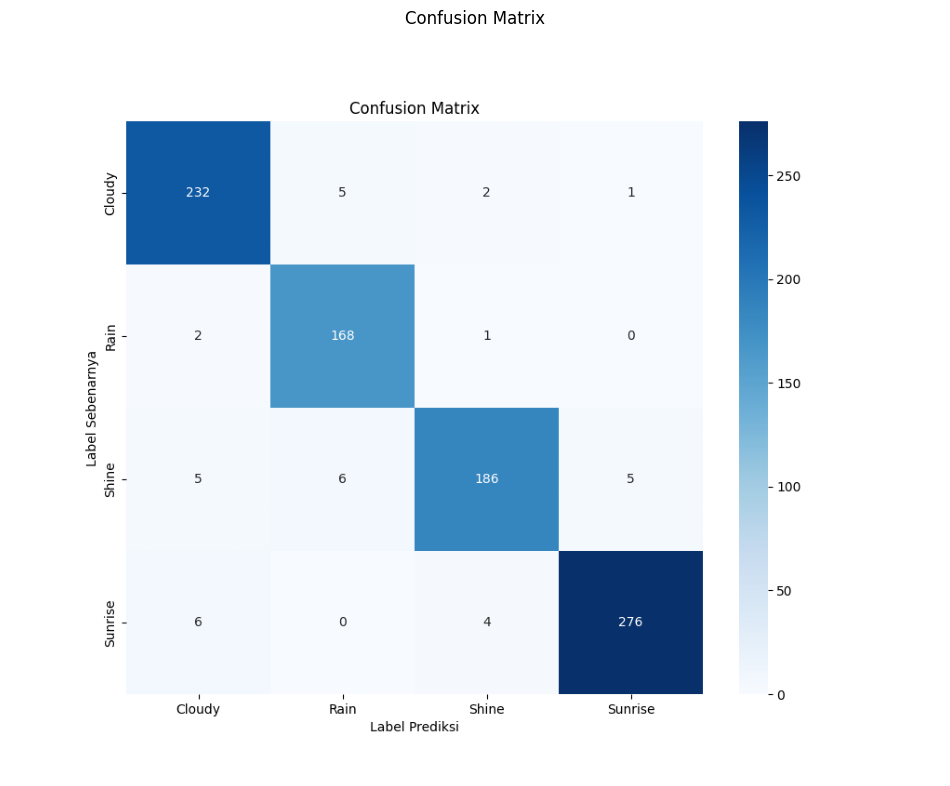

In [ ]:
cm_path = os.path.join(RESULTS_PATH, 'confusion_matrix.png')
try:
    img = mpimg.imread(cm_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.title('Confusion Matrix')
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"File confusion matrix tidak ditemukan di: {cm_path}")